# Goal
The previous attempt to calculate custom ellipses for each file worked well, but having the user specify the midpoint of the embryo seemed to cause the ellipses to be less accurate. Here I'll try using the two endpoints of the embryo to calculate the ellipse.

In [2]:
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import bokeh
import bokeh.io
bokeh.io.output_notebook()
import bebi103

from imp import reload
import gbeflow

Loading BokehJS ...

/Users/morganschwartz/anaconda3/envs/python36/lib/python3.6/site-packages/bebi103/viz.py:30: UserWarning: DataShader import failed with error "No module named 'datashader'".
Features requiring DataShader will not work and you will get exceptions.
  Features requiring DataShader will not work and you will get exceptions.""")
/Users/morganschwartz/anaconda3/envs/python36/lib/python3.6/site-packages/bebi103/viz.py:38: UserWarning: Could not import `stan` submodule. Perhaps pystan is not properly installed.
  warnings.warn('Could not import `stan` submodule. Perhaps pystan is not properly installed.')
/Users/morganschwartz/anaconda3/envs/python36/lib/python3.6/site-packages/bebi103/__init__.py:19: UserWarning: Could not import `stan` submodule. Perhaps pystan is not properly installed.
  warnings.warn('Could not import `stan` submodule. Perhaps pystan is not properly installed.')


In [9]:
files = glob.glob('../data/*.czi')
files

['../data/20180108_htl_glc_sc11_mmzm.czi',
 '../data/20180112_htlglc_tl_sc19_mmzp.czi',
 '../data/20180110_htl_glc_sc14_mmzp.czi',
 '../data/20180110_htl_glc-Create Image Subset-02_sc11_htl.czi',
 '../data/20180112_htlglc_tl_sc11_mmzp.czi',
 '../data/20180110_htl_glc_sc15_mmzm.czi',
 '../data/20180110_htl_glc-Create Image Subset-01_sc10_wt.czi',
 '../data/20180108_htl_glc_sc9_mmzp.czi',
 '../data/20180112_htlglc_tl_sc4_resille.czi',
 '../data/20180110_htl_glc_sc6_mmzm.czi',
 '../data/20180108_htl_glc_sc2_mmzm_wp.czi']

# Import brightfield data from h5 files

In [10]:
raw = {}
for f in files:
    raw[f] = gbeflow.CziImport(f,summary=False)
    print(f)

../data/20180108_htl_glc_sc11_mmzm.czi
../data/20180112_htlglc_tl_sc19_mmzp.czi
../data/20180110_htl_glc_sc14_mmzp.czi
../data/20180110_htl_glc-Create Image Subset-02_sc11_htl.czi
../data/20180112_htlglc_tl_sc11_mmzp.czi
../data/20180110_htl_glc_sc15_mmzm.czi
../data/20180110_htl_glc-Create Image Subset-01_sc10_wt.czi
../data/20180108_htl_glc_sc9_mmzp.czi
../data/20180112_htlglc_tl_sc4_resille.czi
../data/20180110_htl_glc_sc6_mmzm.czi
../data/20180108_htl_glc_sc2_mmzm_wp.czi


# Mark enpoints of embryos

In [11]:
clicks = []
for f in files:
    clk = bebi103.viz.record_clicks(raw[f].data[1,0],flip=False)
    clicks.append(clk)

In [13]:
Ldf = []
for clk in clicks:
    Ldf.append(clk.to_df())
    
points = pd.concat(Ldf,keys=files)
points

x            y
../data/20180108_htl_glc_sc11_mmzm.czi             0   676.256410   995.531429
                                                   1   348.358974    57.828571
../data/20180112_htlglc_tl_sc19_mmzp.czi           0    21.461538   654.822857
                                                   1  1021.948718   421.851429
../data/20180110_htl_glc_sc14_mmzp.czi             0   234.782051   939.268571
                                                   1   695.666667    29.760000
../data/20180110_htl_glc-Create Image Subset-02... 0    12.551282   620.800000
                                                   1  1019.217949   541.520000
../data/20180112_htlglc_tl_sc11_mmzp.czi           0   626.358974  1005.188571
                                                   1   436.589744    24.765714
../data/20180110_htl_glc_sc15_mmzm.czi             0   472.012821  1004.468571
                                                   1   450.410256     5.108571
../data/20180110_htl_glc-Create Image Subset-01... 0     2.589744   514.777143
                                                   1  1020.346154   475.371429
../data/20180108_htl_glc_sc9_mmzp.czi              0   634.564103  1019.737143
                                                   1   361.282051     1.680000
../data/20180112_htlglc_tl_sc4_resille.czi         0   733.410256   978.274286
                                                   1   218.769231    41.474286
../data/20180110_htl_glc_sc6_mmzm.czi              0   838.243590   984.480000
                                                   1   166.461538   166.971429
../data/20180108_htl_glc_sc2_mmzm_wp.czi           0   193.525641   861.588571
                                                   1   933.205128   109.622857

# Test ellipse calculation based on endpoints

In [14]:
f

'../data/20180108_htl_glc_sc2_mmzm_wp.czi'

In [15]:
df = points.loc[f]
df

x           y
0  193.525641  861.588571
1  933.205128  109.622857

Calculate the length of the embryo based on the distance between the two points.

$$ \text{l} = \sqrt{(x_0-x_1)^2 + (y_0-y_1)^2} $$

In [16]:
l = np.sqrt((df.iloc[1].x - df.iloc[0].x)**2 + (df.iloc[1].y - df.iloc[0].x)**2)
l

744.4228777364316

Scale `l` by 1.2 for cushion and divided by 2 to get the radius for the ellipse

In [48]:
radius = (l/2)*1.5
radius

558.3171583023237

Calculate the ellipse around the centerpoint (0,0) using `radius` as the x_radius and estimating y_radius.

In [56]:
ellipse = gbeflow.calc_ellipse(0,0,radius,300)

In [57]:
p = bokeh.plotting.figure(plot_width=400,plot_height=400,
                         match_aspect=True)
p.line(ellipse[:,0],ellipse[:,1])
bokeh.io.show(p)

Now that the ellipse looks approximately the size of the embryo, it needs to be rotated to match the angle of the embryo.
$$ \theta = \arctan{\left(\frac{y_0-y_1}{x_0-x_1}\right)} $$

In [58]:
theta = np.arctan2(df.iloc[0].y-df.iloc[1].y, df.iloc[0].x-df.iloc[1].x)
theta

2.347957981094862

The ellipse can now be rotated according to the following rotation matrix
\begin{bmatrix}
   \cos{\theta} & -\sin{\theta} \\
   \sin{\theta} & \cos{\theta} \\
  \end{bmatrix}

In [59]:
theta = -theta
R = np.array([[np.cos(theta),-np.sin(theta)],
             [np.sin(theta),np.cos(theta)]])
rellipse = np.dot(ellipse,R)

In [60]:
p = bokeh.plotting.figure(match_aspect=True)
p.line(rellipse[:,0],rellipse[:,1])
bokeh.io.show(p)

Calculate center point between two end points and translate ellipse to be centered on that point.

I am assuming that the zeroth point is the leftmost point in the embryo

In [61]:
centerx = np.abs(df.iloc[0].x - df.iloc[1].x)/2
centery = np.abs(df.iloc[0].y - df.iloc[1].y)/2
centerx,centery

(369.8397435897436, 375.98285714285714)

In [62]:
yshift = df.y.min()
xshift = df.x.min()

centerx = centerx + xshift
centery = centery + yshift
centerx,centery

(563.3653846153846, 485.60571428571427)

In [63]:
p = bebi103.viz.imshow(raw[f].data[1,0],flip=False)
p.line(rellipse[:,0],rellipse[:,1],line_width=3,color='red')
p.line(rellipse[:,0]+centerx,rellipse[:,1]+centery,color='red',line_width=3)
p.scatter(df.x,df.y,color='white',size=10)
p.scatter(centerx,centery,color='red',size=10)
p.line(df.x,df.y,color='white')

bokeh.io.show(p)

Now we can test how well this starting ellipse masks the embryo.

In [66]:
from skimage.segmentation import active_contour
from skimage.filters import gaussian

In [68]:
snake = active_contour(gaussian(raw[f].data[1,0],3),
                               ellipse,alpha=0.015,beta=10,gamma=0.001)

In [72]:
snake.shape

(400, 2)

In [74]:
p = bokeh.plotting.figure()
p.line(snake[:,0],snake[:,1])
bokeh.io.show(p)

In [70]:
p = bebi103.viz.imshow(raw[f].data[1,0],flip=False)
p.line(snake[:,0],snake[:,1],line_width=3,color='red')
p.line(rellipse[:,0]+centerx,rellipse[:,1]+centery,color='red',line_width=3)
bokeh.io.show(p)

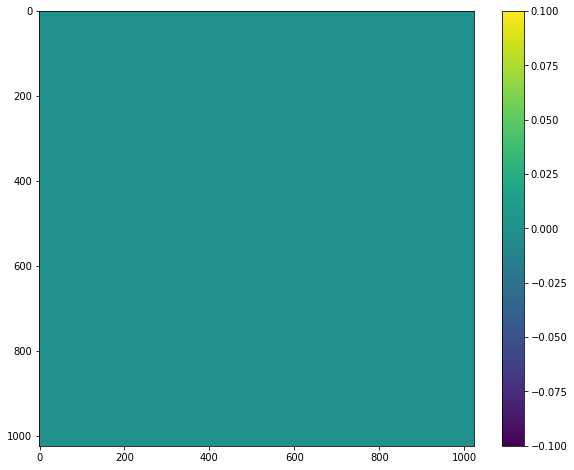

In [64]:
gbeflow.imshow(gbeflow.contour_embryo(raw[f].data[1,0],ellipse))